In [378]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings


from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB




import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns



In [379]:

# At first we mount the dataset from local file
inputdf = pd.read_csv('Crime.csv')
# sneak peak in the data
inputdf.head(2)


,Incident ID,Offence Code,CR Number,Dispatch Date / Time,NIBRS Code,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,...,Street Prefix,Street Name,Street Suffix,Street Type,Start_Date_Time,End_Date_Time,Latitude,Longitude,Police District Number,Location
0,201219928,1204,180063894,12/21/2018 09:13:13 PM,120,1,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,...,NaN,GEORGIA,NaN,AVE,12/21/2018 09:13:00 PM,NaN,39.03627,-77.0499,4D,"(39.0363, -77.0499)"
1,201301798,5016,200035833,09/13/2020 12:26:58 AM,90Z,1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,...,NaN,COLTRANE,NaN,DR,08/08/2020 05:10:00 PM,08/08/2020 12:00:00 AM,39.27784,-77.2115,5D,"(39.2778, -77.2115)"


In [380]:
print(inputdf.shape)
# 'column names are:' 
inputdf.columns
inputdf.dtypes

(312297, 30)


Incident ID                 int64
Offence Code               object
CR Number                   int64
Dispatch Date / Time       object
NIBRS Code                 object
Victims                     int64
Crime Name1                object
Crime Name2                object
Crime Name3                object
Police District Name       object
Block Address              object
City                       object
State                      object
Zip Code                  float64
Agency                     object
Place                      object
Sector                     object
Beat                       object
PRA                        object
Address Number            float64
Street Prefix              object
Street Name                object
Street Suffix              object
Street Type                object
Start_Date_Time            object
End_Date_Time              object
Latitude                  float64
Longitude                 float64
Police District Number     object
Location      

Analyzing the dataset, we observe that columns -


* Incident ID
* Offence Code
* CR Number
* NIBRS Code
* State (All should be MD)
* Sector, Beat, PRA - meaningless
* Address Number (included in "Block Address")
* Street Prefix (lots of missing values)
* Street Suffix (lots of missing values)
* Police District Number (meaningless)
* Location (pair of Latitude and Longitude)

 are unnecessary. So they are removed.

# Later, Columns related with the effect of crime are removed.

In [381]:
unnecessary_columns = ['Dispatch Date / Time', 'Victims', 'Block Address', 'Street Type', 'Agency', 'End_Date_Time']
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

,Incident ID,Offence Code,CR Number,NIBRS Code,Crime Name1,Crime Name2,Crime Name3,Police District Name,City,State,...,PRA,Address Number,Street Prefix,Street Name,Street Suffix,Start_Date_Time,Latitude,Longitude,Police District Number,Location
0,201219928,1204,180063894,120,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,SILVER SPRING,MD,...,352,11100.0,NaN,GEORGIA,NaN,12/21/2018 09:13:00 PM,39.03627,-77.0499,4D,"(39.0363, -77.0499)"
1,201301798,5016,200035833,90Z,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,DAMASCUS,MD,...,615,25600.0,NaN,COLTRANE,NaN,08/08/2020 05:10:00 PM,39.27784,-77.2115,5D,"(39.2778, -77.2115)"


Some columns are confusing to be added now. Such as -

* Crime Name3
* Zip Code
* Street Name
* Also we have to take special care of Latitude and Longitude if we want them to include in our feature set.

# Drop rows from the dataframe based on certain condition applied on a column


In [382]:
# Filter all rows for Latitude is greater than or equal to 35
inputdf = inputdf[inputdf['Latitude'] > 35.0]
# inputdf['Latitude'].hist()

In [383]:
# Filter all rows for Longitude is less than or equal to -70
inputdf = inputdf[inputdf['Longitude'] < -70]
# inputdf['Longitude'].hist()

In [384]:
# inputdf['Crime Name2'].value_counts()
# # Filter all rows for that has occurances less than 5
# inputdf = inputdf[inputdf.columns[inputdf['Crime Name2'].value_counts() > 5]]

In [385]:
inputdf['Crime Name2'].value_counts()

All Other Offenses                             72203
Theft From Motor Vehicle                       26252
Drug/Narcotic Violations                       22573
Simple Assault                                 21064
Destruction/Damage/Vandalism of Property       18967
Shoplifting                                    16416
All other Larceny                              13972
Driving Under the Influence                    13723
Theft from Building                            11335
Burglary/Breaking and Entering                  8784
Identity Theft                                  8633
Theft of Motor Vehicle Parts or Accessories     6747
Liquor Law Violations                           6565
Motor Vehicle Theft                             6489
False Pretenses/Swindle/Confidence Game         6438
Disorderly Conduct                              4980
Credit Card/Automatic Teller Machine Fraud      4726
Aggravated Assault                              4313
Trespass of Real Property                     

# Export Pandas DataFrame to CSV


In [386]:

# inputdf.to_csv('potential feature set revised.csv')

# Creating The Location Based Crime Data Frame

In [409]:
# loc_crime_df = inputdf[['Latitude', 'Longitude', 'Crime Name1']]
loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Zip Code', 'Place', 'Street Name', 'Latitude', 'Longitude']]
dates = pd.to_datetime(inputdf['Start_Date_Time'])
  
# extract Hours from Timestamp 
# rs = dates.dt.hour
# print(rs)
loc_crime_df['dateHour'] = dates.dt.hour
loc_crime_df['day'] = dates.dt.day_name()
loc_crime_df['month'] = dates.dt.month
loc_crime_df.head()
# print(loc_crime_df.shape)
# loc_crime_df.dtypes
# loc_crime_df['Crime Name1'].value_counts()


,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
0,Crime Against Property,Robbery,WHEATON,SILVER SPRING,20902.0,Street - Bus Stop,GEORGIA,39.036270,-77.049900,21,Friday,12
1,Crime Against Society,All Other Offenses,GERMANTOWN,DAMASCUS,20872.0,Parking Lot - Residential,COLTRANE,39.277840,-77.211500,17,Saturday,8
2,Crime Against Society,Driving Under the Influence,ROCKVILLE,ROCKVILLE,20850.0,Street - In vehicle,GRANDIN,39.086688,-77.144754,2,Thursday,1
3,Other,All Other Offenses,ROCKVILLE,ROCKVILLE,20850.0,Street - Other,GRANDIN,39.086688,-77.144754,2,Thursday,1
4,Crime Against Property,Shoplifting,GERMANTOWN,GERMANTOWN,20876.0,Retail - Department/Discount Store,FREDERICK,39.198295,-77.244900,17,Thursday,7


In [410]:
 # Removing Rows on Count condition
counts = loc_crime_df['Crime Name2'].value_counts()
# print(counts)
threshold = 100
loc_crime_df = loc_crime_df.loc[loc_crime_df['Crime Name2'].isin(counts.index[counts >= threshold ])]
# loc_crime_df['Crime Name1'].value_counts()


In [411]:
 # Removing Rows on Count condition 
 # Pruning garbage data
# loc_crime_df = loc_crime_df[~loc_crime_df['Crime Name2'] == "All Other Offenses"]
indexAge = loc_crime_df[ loc_crime_df['Crime Name2'] == "All Other Offenses" ].index
loc_crime_df.drop(indexAge , inplace=True)

counts = loc_crime_df['Crime Name2'].value_counts()
# print(counts)

loc_crime_df['Crime Name1'].value_counts()

Crime Against Property    140065
Crime Against Society      57349
Crime Against Person       29920
Not a Crime                 3590
Other                        486
Name: Crime Name1, dtype: int64

In [412]:
loc_crime_df.head()

,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
0,Crime Against Property,Robbery,WHEATON,SILVER SPRING,20902.0,Street - Bus Stop,GEORGIA,39.036270,-77.049900,21,Friday,12
2,Crime Against Society,Driving Under the Influence,ROCKVILLE,ROCKVILLE,20850.0,Street - In vehicle,GRANDIN,39.086688,-77.144754,2,Thursday,1
4,Crime Against Property,Shoplifting,GERMANTOWN,GERMANTOWN,20876.0,Retail - Department/Discount Store,FREDERICK,39.198295,-77.244900,17,Thursday,7
5,Crime Against Person,Forcible Rape,MONTGOMERY VILLAGE,GAITHERSBURG,20879.0,Residence - Apartment/Condo,SNOUFFER SCHOOL,39.168194,-77.175049,14,Monday,9
6,Crime Against Society,Prostitution,ROCKVILLE,ROCKVILLE,20850.0,Retail - Salon/Spa,FREDERICK,39.103443,-77.155941,12,Thursday,2


# Taking only Top n classes in a column


In [413]:
target_column = 'Crime Name2'
top_n = 10
top_classes = {}
top_classes = loc_crime_df[target_column].value_counts().nlargest(top_n).to_dict()
print(top_classes)
str_array = []
temp_df = pd.DataFrame()
for x in top_classes.keys():
    str_array.append(x)
    rows = loc_crime_df[loc_crime_df[target_column] == str (x) ]
    # print(rows)
    temp_df = temp_df.append(rows)
# print(str_array)
# temp_df


{'Theft From Motor Vehicle': 26252, 'Drug/Narcotic Violations': 22573, 'Simple Assault': 21064, 'Destruction/Damage/Vandalism of Property': 18967, 'Shoplifting': 16416, 'All other Larceny': 13972, 'Driving Under the Influence': 13723, 'Theft from Building': 11335, 'Burglary/Breaking and Entering': 8784, 'Identity Theft': 8633}


In [414]:
# print(temp_df[target_column].value_counts())
loc_crime_df = temp_df

# "Crime name 1" got reduced from 5 category to 3 category 


print(loc_crime_df[target_column].value_counts())
loc_crime_df['Crime Name1'].value_counts()

Theft From Motor Vehicle                    26252
Drug/Narcotic Violations                    22573
Simple Assault                              21064
Destruction/Damage/Vandalism of Property    18967
Shoplifting                                 16416
All other Larceny                           13972
Driving Under the Influence                 13723
Theft from Building                         11335
Burglary/Breaking and Entering               8784
Identity Theft                               8633
Name: Crime Name2, dtype: int64


Crime Against Property    104359
Crime Against Society      36296
Crime Against Person       21064
Name: Crime Name1, dtype: int64

# Handling null values in Zip code

In [415]:
# Replacing null values with mode value in Zip code
print(loc_crime_df.shape)
missing_value_column = 'Zip Code'
loc_crime_df[missing_value_column].fillna(loc_crime_df[missing_value_column].mode()[0], inplace=True)
print(loc_crime_df.shape)

(161719, 12)
(161719, 12)


In [416]:
# # Dropping null values in Zip code
# print(loc_crime_df.shape)
# # print(loc_crime_df['Zip Code'].value_counts())
# # loc_crime_df['dateHour'].value_counts()
# loc_crime_df = loc_crime_df.dropna(axis=0, subset=['Zip Code'])
# print(loc_crime_df.shape)

In [417]:
# loc_crime_df['Crime Name2'].count()
loc_crime_df['Crime Name1'].value_counts()

Crime Against Property    104359
Crime Against Society      36296
Crime Against Person       21064
Name: Crime Name1, dtype: int64

# Plots for Paper Motivation

In [418]:
# When deep=True (default), a new object will be created with a copy of the calling object’s data and indices. Modifications to the data or indices of the copy will not be reflected in the original object
plot_df = loc_crime_df.copy(deep=True)

In [419]:
loc_crime_df['Crime Name2'].value_counts()

Theft From Motor Vehicle                    26252
Drug/Narcotic Violations                    22573
Simple Assault                              21064
Destruction/Damage/Vandalism of Property    18967
Shoplifting                                 16416
All other Larceny                           13972
Driving Under the Influence                 13723
Theft from Building                         11335
Burglary/Breaking and Entering               8784
Identity Theft                               8633
Name: Crime Name2, dtype: int64

# Now we have to visualize the data and fix what to predict from these modified feature set

PROJCS["NAD83 / Maryland (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",37.6666666666667],PARAMETER["central_meridian",-77],PARAMETER["standard_parallel_1",38.3],PARAMETER["standard_parallel_2",39.45],PARAMETER["false_easting",1312333.33333333],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


<AxesSubplot:>

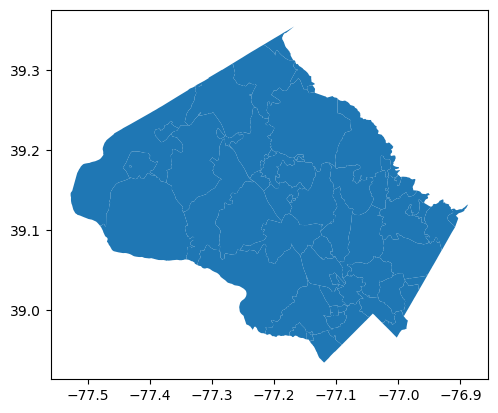

In [420]:
# Montgomery County maintained roads
# https://data.imap.maryland.gov/datasets/maryland::montgomery-county-maintained-roads/explore?location=39.168559%2C-76.905435%2C9.35
# https://catalog.data.gov/dataset/tiger-line-shapefile-2018-county-montgomery-county-md-all-roads-county-based-shapefile
# crs = {'init':'EPSG:4326'}
montgomery_county_map = gpd.read_file('Zipcodes.shp')
print(montgomery_county_map.crs) 
montgomery_county_map.to_crs(epsg=4326).plot()

# Other sources for multiple data view
# https://montgomeryplanning.org/tools/gis-and-mapping/map-library/

# ‘geo_df’ that is a copy of our original data frame but with the newly created ‘geometry’ column

In [421]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(plot_df['Longitude'], plot_df['Latitude'])]
geo_df = gpd.GeoDataFrame(plot_df, 
                          crs = crs, 
                          geometry = geometry)

# geo_df.head()
# geo_df.plot() - nothing meaningful

# Visualizing the Crime Data

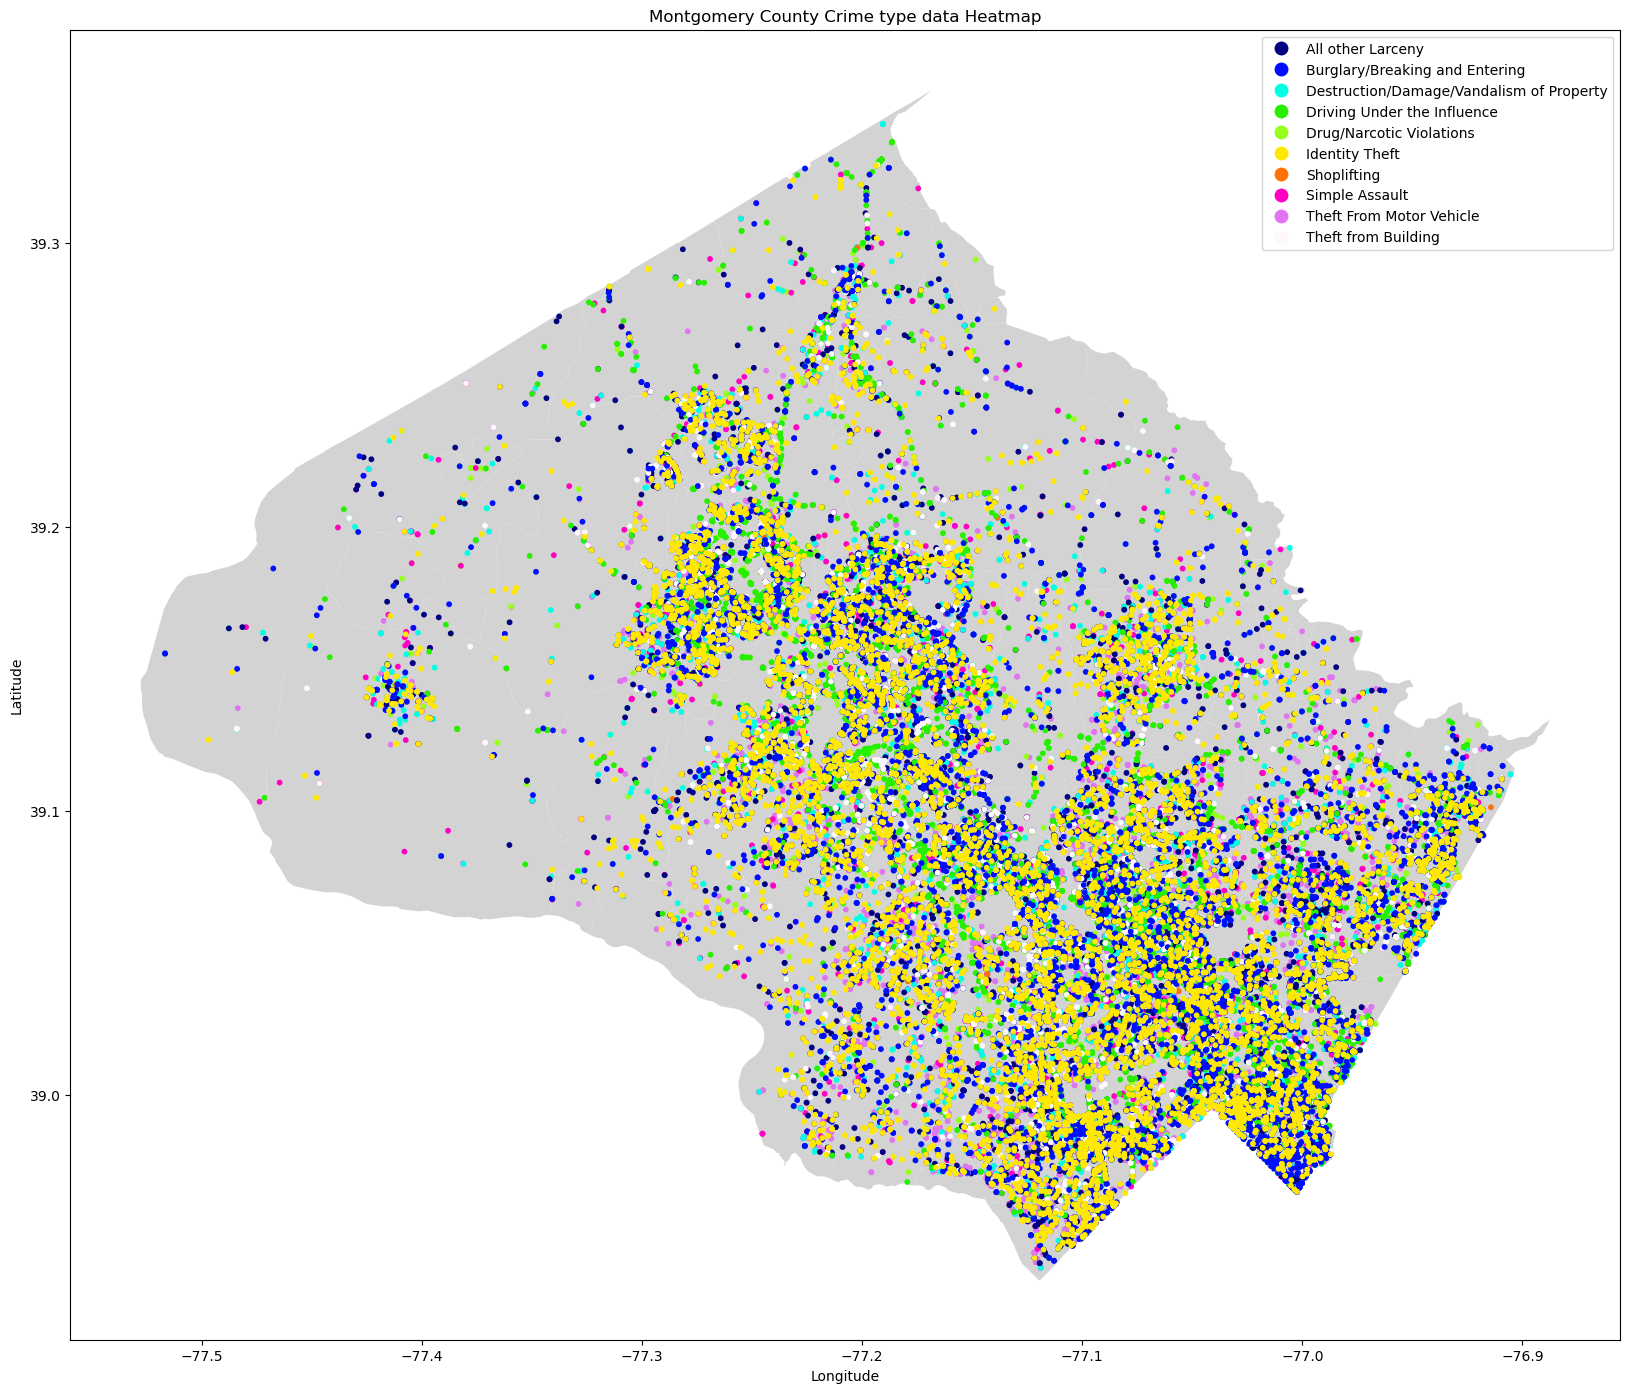

In [422]:
fig, ax = plt.subplots(figsize = (20,20))
montgomery_county_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = geo_df[target_column], ax=ax, cmap = 'gist_ncar',
            legend = True, #legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title('Montgomery County Crime type data Heatmap')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.savefig('Montgomery County Crime Heat Map for Location')

In [423]:
plot_df.head()

,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month,geometry
20,Crime Against Property,Theft From Motor Vehicle,SILVER SPRING,SILVER SPRING,20904.0,Parking Lot - Commercial,BRIGGS CHANEY,39.08299,-76.9481,11,Sunday,11,POINT (-76.94810 39.08299)
31,Crime Against Property,Theft From Motor Vehicle,ROCKVILLE,ROCKVILLE,20852.0,Parking Lot - Commercial,JEFFERSON,39.05840,-77.1263,20,Thursday,1,POINT (-77.12630 39.05840)
61,Crime Against Property,Theft From Motor Vehicle,SILVER SPRING,SILVER SPRING,20904.0,Parking Lot - Commercial,PROSPERITY,39.06081,-76.9634,10,Friday,9,POINT (-76.96340 39.06081)
98,Crime Against Property,Theft From Motor Vehicle,BETHESDA,CHEVY CHASE,20815.0,Residence - Driveway,GLENMOOR,39.00547,-77.0720,20,Tuesday,12,POINT (-77.07200 39.00547)
116,Crime Against Property,Theft From Motor Vehicle,GERMANTOWN,GERMANTOWN,20874.0,Parking Lot - Residential,SWISS,39.15549,-77.2763,18,Sunday,12,POINT (-77.27630 39.15549)


# Transform the data by label encoding

In [431]:
encoded_dict ={}
temp_df_2 = pd.DataFrame()

def label_encoder(y):
    le = LabelEncoder()
    if str(y) == target_column:
        print(loc_crime_df[y])
    loc_crime_df[y] = le.fit_transform(loc_crime_df[y])
    if str(y) == target_column:
        print(loc_crime_df[y])
    if str(y) == target_column:
        temp_df_2[y] = le.inverse_transform(loc_crime_df[y])
        # encoded_dict = {loc_crime_df[y], temp_df_2[y]} 
    #print(temp_df[y])

#loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']]

label_list = ['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name', 'day']
#label_list = ['Crime Name1']

for l in label_list:
    label_encoder(l)

# print(encoded_dict)
 
#Display transformed data
loc_crime_df.head()

20        8
31        8
61        8
98        8
116       8
         ..
312116    5
312129    5
312201    5
312240    5
312248    5
Name: Crime Name2, Length: 161719, dtype: int32
20        8
31        8
61        8
98        8
116       8
         ..
312116    5
312129    5
312201    5
312240    5
312248    5
Name: Crime Name2, Length: 161719, dtype: int64


,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
20,1,8,6,34,20904.0,45,835,39.08299,-76.9481,11,3,11
31,1,8,5,32,20852.0,45,3389,39.05840,-77.1263,20,4,1
61,1,8,6,34,20904.0,45,5132,39.06081,-76.9634,10,0,9
98,1,8,0,11,20815.0,61,2643,39.00547,-77.0720,20,5,12
116,1,8,2,19,20874.0,51,6202,39.15549,-77.2763,18,3,12


In [432]:
# print(loc_crime_df['Crime Name1'].value_counts())
# print(temp_df['Crime Name1'].value_counts())

# Separating Train and Test Set for Crime Prediction

In [433]:
# # Going for specific prediction with geolocation
# X = loc_crime_df.drop([target_column],axis=1)
# y = loc_crime_df[target_column]

# Going for specific prediction without geolocation
X = loc_crime_df.drop([target_column, 'Latitude', 'Longitude'],axis=1)
y = loc_crime_df[target_column]


# Going for generic prediction
# X = loc_crime_df.drop([target_column,'Crime Name2', 'Latitude', 'Longitude'],axis=1)
# y = loc_crime_df[target_column]

# Going for specific crime with geolocation prediction with geolocation


print(X)


        Crime Name1  Police District Name  City  Zip Code  Place  Street Name  \
20                1                     6    34   20904.0     45          835   
31                1                     5    32   20852.0     45         3389   
61                1                     6    34   20904.0     45         5132   
98                1                     0    11   20815.0     61         2643   
116               1                     2    19   20874.0     51         6202   
...             ...                   ...   ...       ...    ...          ...   
312116            1                     5    32   20852.0     37         5275   
312129            1                     2     6   20841.0     37         3546   
312201            1                     2    19   20874.0     37           79   
312240            1                     5    17   20878.0     37         5844   
312248            1                     2    12   20871.0     15         1492   

        dateHour  day  mont

In [434]:
print(y)

20        8
31        8
61        8
98        8
116       8
         ..
312116    5
312129    5
312201    5
312240    5
312248    5
Name: Crime Name2, Length: 161719, dtype: int64


In [435]:
print(y.value_counts())

8    26252
4    22573
7    21064
2    18967
6    16416
0    13972
3    13723
9    11335
1     8784
5     8633
Name: Crime Name2, dtype: int64


In [436]:
#Split the data into training and testing set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=42, shuffle = True) 

#Data was splitted as 80% train data and 20% test data.

# y_train = y_train.values.reshape(-1,1)
# y_test = y_test.values.reshape(-1,1)

print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train shape: (129375, 9)
X_test shape: (32344, 9)
y_train shape: (129375,)
y_test shape: (32344,)


In [437]:
#Feature Scaling (Standardize the data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# sc= MinMaxScaler()
# y_train = sc.fit_transform(y_train)
# y_test = sc.transform(y_test)

# We will build all six models and compare their accuracy scores.



In [438]:
#To store results of models, we create two dictionaries
result_dict_train = {}
result_dict_test = {}

# Machine Leaning Models and their performance


In [439]:
models = {'Naïve Bayes Classifier': GaussianNB, 'Decision Tree Classifier' : DecisionTreeClassifier, 'KNN Classifier': KNeighborsClassifier,
        'Random Forest Classifier': RandomForestClassifier,'Logistic Regression': LogisticRegression}
        # , 'Support Vector Classifier': SVC}
# for keys, values in sorted(models.items()):
#     print(keys +" is "+ values)

warnings.filterwarnings("ignore")

# for name, model in models.items():
#     print(name +" is "+ model)
    

Naïve Bayes Classifier is running
Train Score: 0.4359574879227052
Test Score: 0.4331251545881771


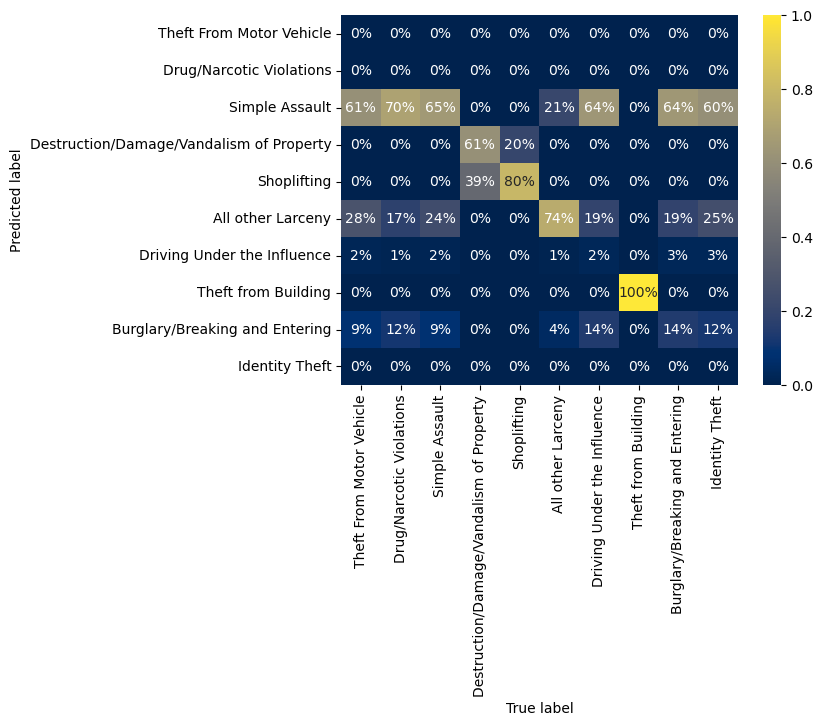

Decision Tree Classifier is running
Train Score: 0.586071497584541
Test Score: 0.5884244372990354


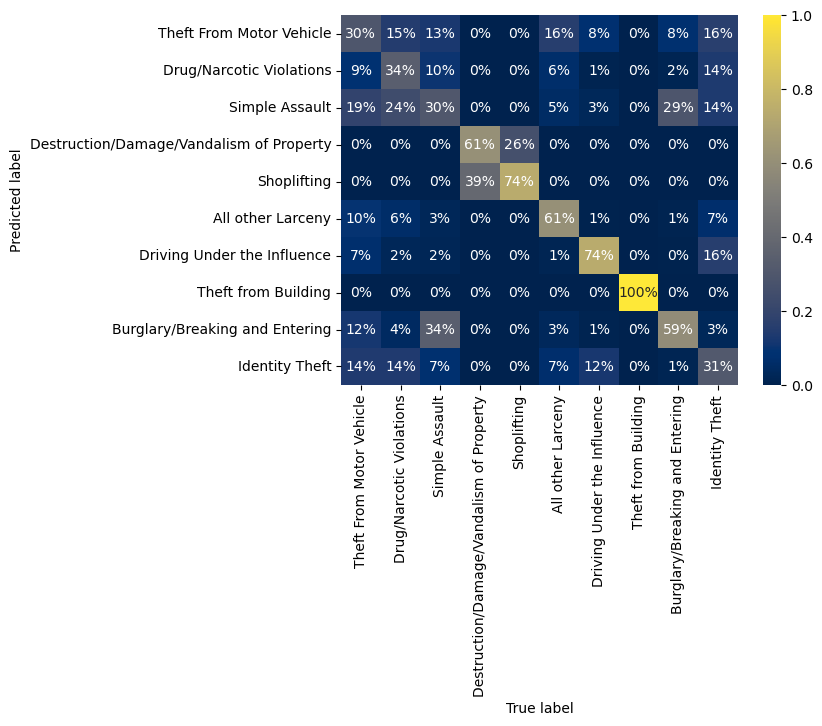

KNN Classifier is running
Train Score: 0.5494106280193236
Test Score: 0.5542913677961909


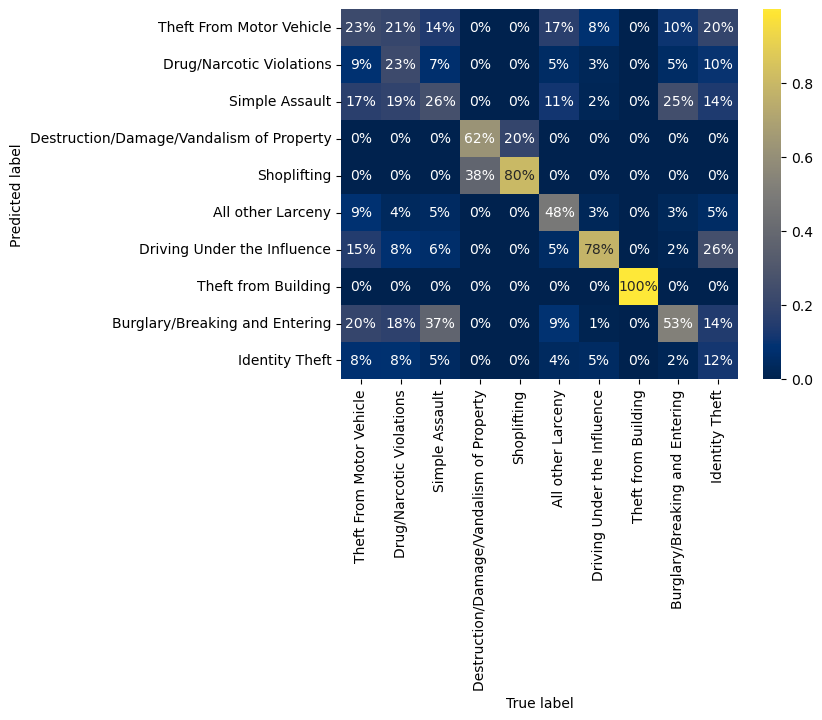

Random Forest Classifier is running
Train Score: 0.6529700483091787
Test Score: 0.648775661637398


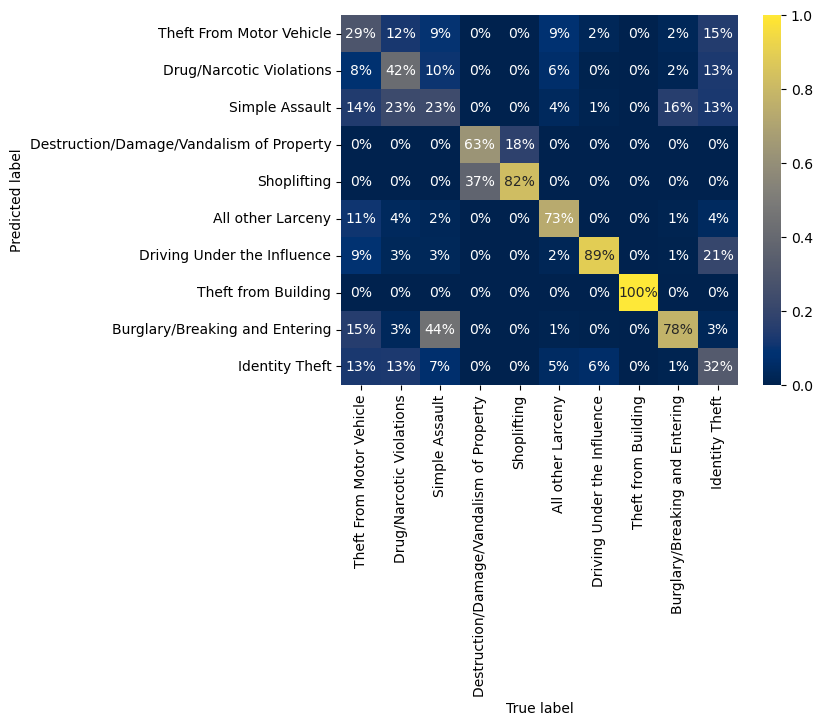

Logistic Regression is running
Train Score: 0.4657855072463769
Test Score: 0.46197130843433093


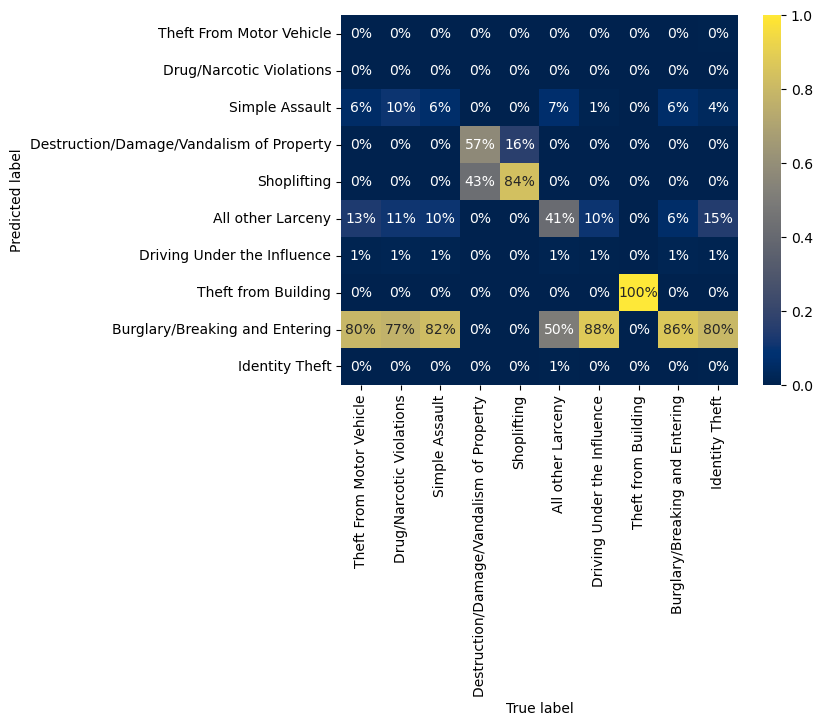

In [440]:
for model_name, model_function in models.items():
    print(model_name +' is running')
    try:
        model = model_function(random_state = 42)
    except:
        if(model_name=='Logistic Regression'):
            model = model_function(solver='lbfgs', max_iter=1000)
        model = model_function()
    accuracies = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    #Obtain accuracy
    print("Train Score:",np.mean(accuracies))
    print("Test Score:",model.score(X_test,y_test))
    # print("Test Score (F1 - micro):",f1_score(y_test, y_pred, average='micro'))
    # print("Test Score (F1 - macro):",f1_score(y_test, y_pred, average='macro'))
    # print("Test Score (F1 - weighted):",f1_score(y_test, y_pred, average='weighted'))

    #Confusion matrix
    # plot_confusion_matrix(model, X_test, y_test)  
    # plt.show()

    
    # # # Plot non-normalized confusion matrix
    # titles_options = [
    #     ("Normalized confusion matrix", "true"),
    # ]
    # for title, normalize in titles_options:
    #     disp = ConfusionMatrixDisplay.from_estimator(
    #         model,
    #         X_test,
    #         y_test,
    #         display_labels=str_array,
    #         cmap=plt.cm.Blues,
    #         normalize=normalize,
    #         xticks_rotation=90,
    #         #yticks_rotation=75,
    #     )
    #     disp.ax_.set_title(title)
    #     # ax[0].set_xticklabels(df_result_train.index,rotation = 75)
    #     # ax[1].set_xticklabels(df_result_test.index,rotation = 75)

    #     print(title)
    #     #print(disp.confusion_matrix)

    # plt.show()

    
    # Create the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred, normalize="true")
    # Plot the confusion matrix
    sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=str_array, yticklabels=str_array)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.show()

    #Store results in the dictionaries
    result_dict_train['Train Score for '+model_name] = np.mean(accuracies)
    result_dict_test['Test Score for '+model_name] = model.score(X_test,y_test)
    


# Compare Accuracy Scores

In [441]:
df_result_train = pd.DataFrame.from_dict(result_dict_train,orient = "index", columns=["Score"])
print(df_result_train)

df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index",columns=["Score"])
df_result_test


                                             Score
Train Score for Naïve Bayes Classifier    0.435957
Train Score for Decision Tree Classifier  0.586071
Train Score for KNN Classifier            0.549411
Train Score for Random Forest Classifier  0.652970
Train Score for Logistic Regression       0.465786


,Score
Test Score for Naïve Bayes Classifier,0.433125
Test Score for Decision Tree Classifier,0.588424
Test Score for KNN Classifier,0.554291
Test Score for Random Forest Classifier,0.648776
Test Score for Logistic Regression,0.461971


# Display the accuracy scores

[Text(0, 0, 'Test Score for Naïve Bayes Classifier'),
 Text(1, 0, 'Test Score for Decision Tree Classifier'),
 Text(2, 0, 'Test Score for KNN Classifier'),
 Text(3, 0, 'Test Score for Random Forest Classifier'),
 Text(4, 0, 'Test Score for Logistic Regression')]

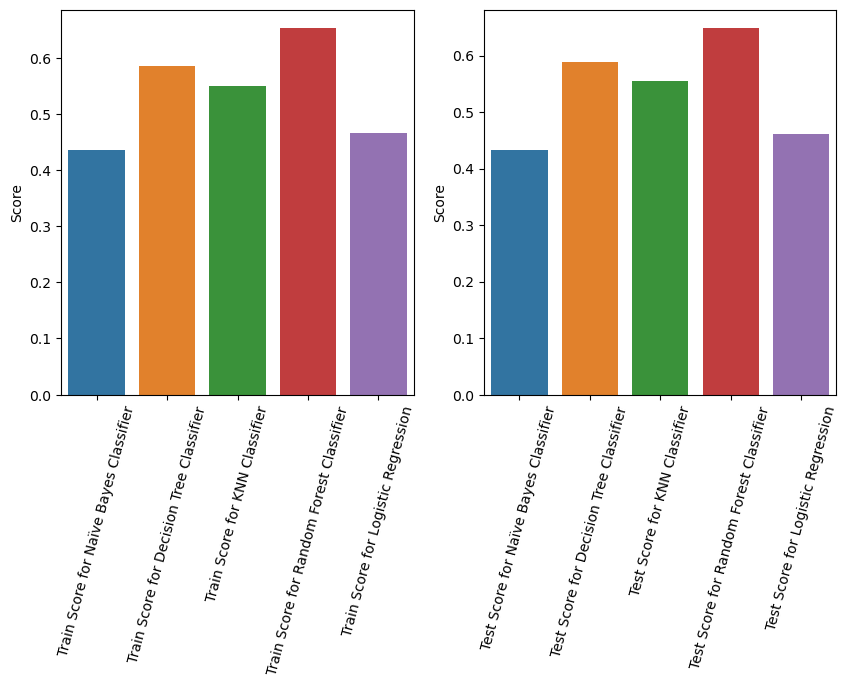

In [442]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x = df_result_train.index,y = df_result_train.Score,ax = ax[0])
sns.barplot(x = df_result_test.index,y = df_result_test.Score,ax = ax[1])
ax[0].set_xticklabels(df_result_train.index,rotation = 75)
ax[1].set_xticklabels(df_result_test.index,rotation = 75)
#plt.show()
# plt.savefig('Predicting Specific Crime With Location')